##### Import Library

In [1]:
# Importing Library
from simpleparamaterisation import TPCevt as TPC
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from ROOT import TFile, TTree

Welcome to JupyROOT 6.28/00


##### Helper Function and Constant

In [2]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)

nsigma_extend=3
thresh=1e1

##### Main Function

In [3]:
def getData(f, saveevt):
    # Get Center Coordinate
    max_z = 0
    min_z = 0
    for evt in f.data:
        if evt.z0 > max_z:
            max_z = evt.z0
        if evt.z0 < min_z:
            min_z = evt.z0
    center_z = (max_z - min_z)/2
    
    # Shift Coordinate
    for i, evt in enumerate(f.data):
        PrimaryEvt = pd.DataFrame({'x': np.asarray(evt.x)/10 + center_z/10, 'y': np.asarray(evt.y)/10 + center_z/10, 
                        'z': np.asarray(evt.z)/10 + center_z/10, 
                    'Edep': np.asarray(evt.edep)*1000})
        if i == saveevt:
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    PrimaryEvt['NIP'] = np.random.poisson(PrimaryEvt['Edep']/det.wval)

def driftCarriers(PrimaryEvt, det):
    '''
    Drift the primary carriers down to the gain stage.

    Inputs:

    - PrimaryEvt is a Pandas DataFrame with at least (x,y,z,Edep,NIP).

    - det is an instance of TPCevt.Detector, with the gas properties and drift field set.

    Returns a dataframe of drifted carriers with (index in PrimaryEvt, x, y, dt)
    '''
    Ndrifted = int(PrimaryEvt['NIP'].sum())
    if not Ndrifted>0:
        return pd.DataFrame(columns=['idx_PrimaryEvt', 'x', 'y', 'dt'])
    #drifteddict = {'idx_PrimaryEvt': np.empty(Ndrifted, dtype=np.int), 'x': np.empty(Ndrifted, dtype=np.float),
    #              'y': np.empty(Ndrifted, dtype=np.float), 'dt': np.empty(Ndrifted, dtype=np.float)}
    DriftedEvt = pd.DataFrame(columns=['idx_PrimaryEvt', 'x', 'y', 'dt'], 
            index=np.arange(PrimaryEvt.index[0],Ndrifted+PrimaryEvt.index[0],1))
    counter = int(PrimaryEvt.index[0])
    #offset = int(PrimaryEvt.index[0])
    #This loop assumes the index increases by one unit with each entry.
    for i in PrimaryEvt.index:
        numtodrift = int(PrimaryEvt['NIP'][i])
        thisz = PrimaryEvt['z'][i]
        DriftedEvt['idx_PrimaryEvt'].loc[counter:(counter+numtodrift)-1] = i
        DriftedEvt['x'].loc[counter:(counter+numtodrift)-1] = PrimaryEvt['x'][i] + np.random.normal(loc=0,
                                                                scale=driftsigma_trans(thisz, det),
                                                                size=numtodrift)
        DriftedEvt['y'].loc[counter:(counter+numtodrift)-1] = PrimaryEvt['y'][i] + np.random.normal(loc=0,
                                                                scale=driftsigma_trans(thisz, det),
                                                                size=numtodrift)
        DriftedEvt['dt'].loc[counter:(counter+numtodrift)-1] = (thisz + np.random.normal(loc=0,
                                                                scale=driftsigma_long(thisz, det),
                                                                size=numtodrift))/det.vdrift
        counter += numtodrift
    
    return DriftedEvt

def gainAndReadout(DriftedEvt, det, nsigma_extend=3, thresh=1e1):
    '''
    Apply avalanche gain and read out the event. Only reads out a subset of co-ords about the track, on a grid.
    
    Inputs:

    - DriftedEvt is a dataframe containing the x,y,dt co-ordinates of every drifted carrier.

    - det is an instance of TPCevt.Detector, with the gain/readout info set.

    - nsigma_extend is the # of point spread function std to extend by about the track extremities.

    - thresh is the threshold (in number of electrons, below which the output is cut.

    Returns a pandas dataframe with (x,y,dt) readout co-ordinates and the number of electrons being read out
    '''
    minvals = DriftedEvt.min()
    maxvals = DriftedEvt.max()
    ReadoutGrid = np.mgrid[np.floor((minvals['x']- det.PSFmean - 
                                    nsigma_extend*det.PSFstd)/det.pitch_x)*det.pitch_x:
                            np.ceil((maxvals['x'] + det.PSFmean + 
                                    nsigma_extend*det.PSFstd)/det.pitch_x)*det.pitch_x:
                            det.pitch_x,
                            
                            np.floor((minvals['y'] - det.PSFmean - 
                                nsigma_extend*det.PSFstd)/det.pitch_y)*det.pitch_y:
                            np.ceil((maxvals['y'] + det.PSFmean + 
                                nsigma_extend*det.PSFstd)/det.pitch_y)*det.pitch_y:
                            det.pitch_y,
                            
                            np.floor((minvals['dt'] - 
                                nsigma_extend*det.gain_sigma_t)/det.samplerate)*det.samplerate:
                            np.ceil((maxvals['dt'] + 
                                nsigma_extend*det.gain_sigma_t)/det.samplerate)*det.samplerate:
                            det.samplerate]
    pos = np.stack(ReadoutGrid, axis=3)
    ReadoutEvt = None
    for i in DriftedEvt.index:
        thisGain = np.random.exponential(scale=det.gain_mean) # bikin gain banyak dulu baru di loop
        rv = multivariate_normal([DriftedEvt.iloc[i]['x'], DriftedEvt.iloc[i]['y'], 
            DriftedEvt.iloc[i]['dt']], np.diag([det.PSFstd, det.PSFstd,det.gain_sigma_t]))
        if ReadoutEvt is None:
            #The factor pitch_x*pitch_y*sample_rate converts from probability density 
            #to 'normalised' probability
            ReadoutEvt = rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
        else:
            ReadoutEvt += rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain

    #Only record readout elements where Nel > thresh
    themask = ReadoutEvt >= thresh
    if np.sum(themask) == 0:
        print('No channels above threshold!')
        return pd.DataFrame(columns=['x', 'y', 'dt', 'Nel'])
    try:
        return pd.DataFrame({'x': ReadoutGrid[0][themask].flatten(), 'y': ReadoutGrid[1][themask].flatten(), 
            'dt': ReadoutGrid[2][themask].flatten(), 'Nel': ReadoutEvt[themask]})
    except:
        print(f'DriftedEvt: {DriftedEvt}')
        print(f'themask: {themask}\nReadoutGrid[0]: {ReadoutGrid[0]}\nReadoutEvt: {ReadoutEvt}\nReadoutGrid: {ReadoutGrid}')
        print(f'ReadoutGrid.shape: {ReadoutGrid.shape}, ReadoutEvt.shape: {ReadoutEvt.shape}, themask.shape = {themask.shape}')
        raise

def plotReadout(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*1000)
    plt.title(" X-Y Chart ")
    plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*1000)
    plt.title(" X-dT Chart ")
    plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*1000)
    plt.title(" Y-dT Chart ")
    plt.savefig('export/chart_Y-dT.png')

    plt.show()

##### Main Program

In [14]:
# Define the Detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

# Open ROOT FIle
f = TFile.Open("../archive/simOut_28796KShell.root")

##### Primary Event

In [15]:
PrimaryEvt = pd.DataFrame({'x': np.random.uniform(low=0, high=100, size=1000), 
                        'y': np.random.uniform(low=0, high=100, size=1000), 
                        'z': np.random.uniform(low=0, high=500, size=1000), 
                        'Edep': np.random.uniform(low=0, high=100, size=1000)})
# PrimaryEvt

In [42]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
PrimaryEvt

,x,y,z,Edep
0,23.962170,26.851755,26.814911,0.043670
1,23.962368,26.851991,26.814917,0.083792
2,23.962329,26.852121,26.814934,0.136588
3,23.962125,26.851796,26.814872,0.049380
4,23.961355,26.849986,26.815058,0.021973
5,23.957602,26.848080,26.816329,0.665817
6,23.956783,26.845911,26.814511,0.376015
7,23.957281,26.844575,26.812790,0.433897
8,23.957093,26.846053,26.812740,0.016025
9,23.957713,26.844907,26.813409,1.052442


In [26]:
det.samplerate/det.vdrift

5.882352941176471e-06

##### Carrier Event

In [17]:
%%timeit
generateCarriers(PrimaryEvt, det)

166 µs ± 5.15 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
generateCarriers(PrimaryEvt, det)
PrimaryEvt

,x,y,z,Edep,NIP
0,34.696925,62.832690,146.899981,57.274021,2143
1,62.507637,43.866160,297.274516,32.486659,1221
2,10.699643,15.628804,246.522086,76.596912,2967
3,79.344183,63.596313,19.502113,9.961662,372
4,9.747908,9.522673,429.714999,9.369602,378
...,...,...,...,...,...
995,65.619101,87.047514,352.053169,96.380980,3604
996,28.275932,56.965907,201.358960,4.223858,193
997,52.898841,54.718930,419.757686,70.968915,2751
998,11.801229,91.296291,446.881179,96.741696,3674


##### Drifted Event

In [18]:
%%timeit
DriftedEvt = TPC.drift_carriers(PrimaryEvt, det)

24.4 s ± 2.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
DriftedEvt = TPC.drift_carriers(PrimaryEvt, det)
DriftedEvt

,idx_PrimaryEvt,x,y,dt
0,0,34.756987,62.494583,0.862122
1,0,34.602131,62.249187,0.864205
2,0,34.444845,62.817639,0.864043
3,0,34.975172,62.807289,0.863951
4,0,34.303093,62.757331,0.862773
...,...,...,...,...
1952794,999,35.28877,78.953288,0.569941
1952795,999,35.368836,78.811217,0.570982
1952796,999,35.394237,78.554102,0.572019
1952797,999,35.053111,78.725867,0.571862


##### Readout Event

In [21]:
%%timeit
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=5)

MemoryError: Unable to allocate 70.0 GiB for an array with shape (3, 1026, 1036, 2947) and data type float64

In [47]:
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=5)
ReadoutEvt

,x,y,dt,Nel
0,23.6,26.4,0.157,11.959654
1,23.6,26.5,0.157,113.287011
2,23.6,26.5,0.158,225.400579
3,23.6,26.5,0.159,67.272269
4,23.6,26.6,0.157,503.724926
...,...,...,...,...
217,24.2,27.1,0.159,868.520803
218,24.2,27.1,0.160,120.062695
219,24.2,27.2,0.157,407.293274
220,24.2,27.2,0.158,5533.029501


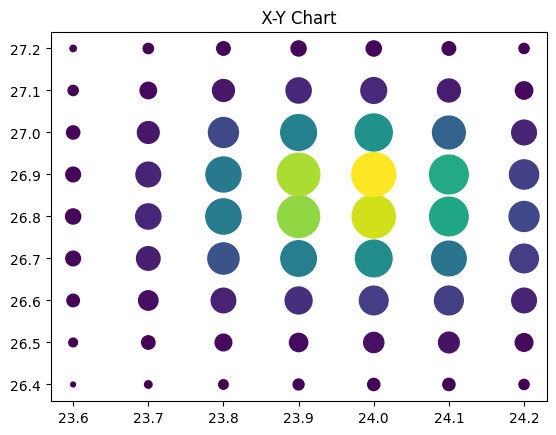

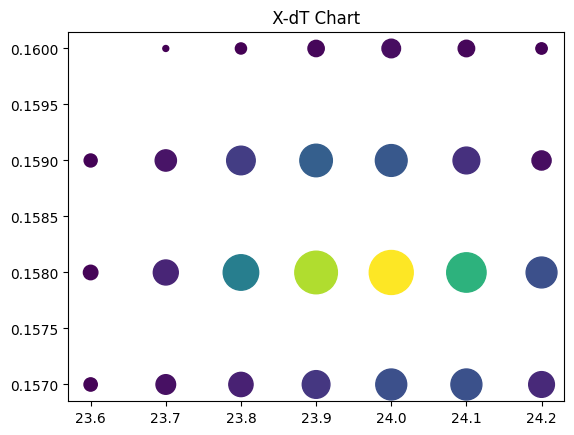

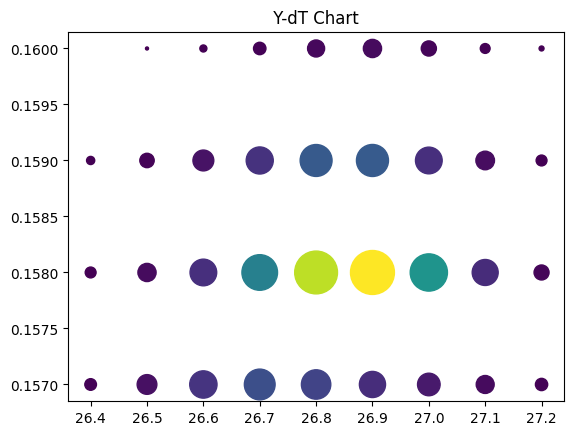

In [10]:
plotReadout(ReadoutEvt)

##### Time Benchmark

In [22]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes


sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('DriftedEvt', 273391892),
 ('PrimaryEvt', 40164),
 ('x', 8112),
 ('LogNorm', 1688),
 ('TFile', 1688),
 ('TTree', 1688),
 ('a', 920),
 ('driftCarriers', 152),
 ('driftsigma_long', 152),
 ('driftsigma_trans', 152),
 ('gainAndReadout', 152),
 ('generateCarriers', 152),
 ('getData', 152),
 ('open', 152),
 ('plotReadout', 152),
 ('TPC', 72),
 ('f', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('det', 56),
 ('multivariate_normal', 56),
 ('truncnorm', 56),
 ('nsigma_extend', 28),
 ('thresh', 24)]